In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import random
import scipy.stats as stats
from matplotlib.patches import Ellipse
import timeit
import time
import tracemalloc
# Load the CSV file into a DataFrame
df = pd.read_csv('bayareapokemon.csv')

In [149]:
def covariance(dat,weights,mean):
    sums,sumsv1,sumsv2 = 0,0,0
    sw = sum(weights)
    for i in range(len(dat)):
        sumsv1 += weights[i]*((dat[i][0]-mean[0])**2)
        sumsv2 += weights[i]*((dat[i][1]-mean[1])**2)
        sums += weights[i]*(dat[i][0]-mean[0])*(dat[i][1]-mean[1])
    cov = sums/sw
    v1 = sumsv1/sw
    v2 = sumsv2/sw
    return [[v1,cov],[cov,v2]]

def meanTup(lst,sw):
    sums = (0,0)
    for i in range(len(lst)):
        sums = (sums[0] + lst[i][0],sums[1] + lst[i][1])
    return (sums[0]/sw,sums[1]/sw)

def meansGetN(dat,weights):
    sumW = sum(weights)
    return meanTup([(x[0] * y,x[1] * y) for x, y in zip(dat, weights)],sumW)

def distance(tup1,tup2,w):
    return (w*(((tup1[0]-tup2[0])**2)+((tup1[1]-tup2[1])**2)))

def getDif(a,b):
    return abs(a[0]-b[0])+abs(a[1]-b[1])

def getChange(m1,cov1,m2,cov2):
    return getDif(m1,m2) + getDif(cov1[0],cov2[0]) + getDif(cov1[1],cov2[1])
    

def Naive_GMM(dat, k,tol):
    data = [(i['lat'],i['lng']) for index,i in dat.iterrows()]
    machineE = tol
    
    covars = []
    weights = [1/k for i in range(k)]
    means = [(random.choice(data)[0],random.choice(data)[1]) for i in range(k)]
    temp = [1/len(data) for i in range(len(data))]
    for i in range(k):
        covars.append(covariance(data,temp,means[i]))
    
    convergenceCriteria = False
    
    count = 0
    
    while not convergenceCriteria:
        dataWeights = []
        
        #figuring out the probability of each datapoint being in a cluster
        SumGausiainWeights = [0 for i in range(k)]
        sums = [0 for i in range(len(data))]
        
        for i in range(k):
            dataWC = []
            weight = weights[i]
            #print(means[i],covars[i])
            currentPdf = stats.multivariate_normal(means[i],covars[i],True)
            for index,row in enumerate(data):
                x = row
                prob = weight*currentPdf.pdf(x) #getting prob in gaussian 
                dataWC.append(prob)
                sums[index] += prob
                SumGausiainWeights[i] += prob
            dataWeights.append(dataWC)
        
        #need to normalize this for probaility of each point to be 1 for the sum of the probabilities for guassian
        
        for index,row in enumerate(data):
            for gaus in range(k):
                dataWeights[gaus][index] = dataWeights[gaus][index]/sums[index]

        
        ##recalculate weights for each gaussian
        SumTotal = len(sums)
        weights = [sum(i)/SumTotal for i in dataWeights]
        
        #Recalculate means and covar
        #get weights correct because they are in 
        
        oldmeans = means
        oldcovars = covars
        
        means = []
        covars = []
        
        
        for i in range(k):
            w = dataWeights[i]
            means.append(meansGetN(data,w))
            covars.append(covariance(data,w,means[i]))
        
        
        #check covergenceCriteria
        change = 0
        for i in range(k):
            change += getChange(oldmeans[i],oldcovars[i],means[i],covars[i])
        
        if count == 1000:
            convergenceCriteria = True
        if change <= machineE:
            convergenceCriteria = True
        count+=1
    return means, covars, weights, dataWeights

In [151]:
means,covars,p_class,p_class_given_data = Naive_GMM(df,5,0.00001)

0.02029472052435139


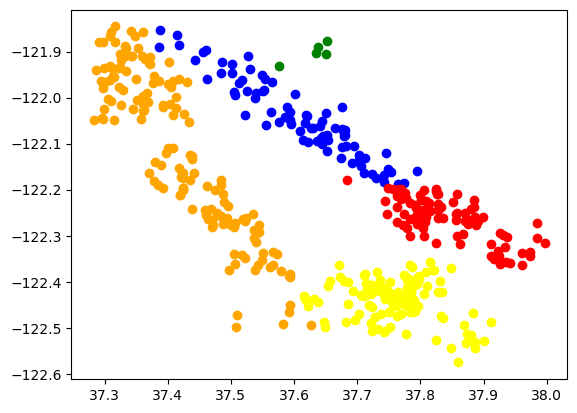

In [152]:
colorDict = {0:'red',1:'yellow',2:'blue',3:'green',4:'orange',5:'cyan',6:'purple',7:'black'}
data = [(i['lat'],i['lng']) for index,i in df.iterrows()]

print(np.sum(np.array(covars)))
for index,row in enumerate(data):
    color = None
    maxVal = 0
    for i in range(5):
        val = p_class_given_data[i][index]
        if val > maxVal:
            color = colorDict[i]
            maxVal = val
    plt.scatter(row[0],row[1],color=color)

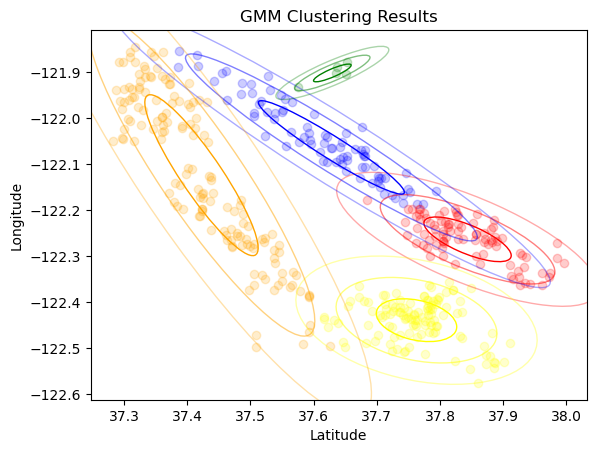

<Figure size 640x480 with 0 Axes>

In [154]:
fig, ax = plt.subplots()
colors= ['red','yellow','blue','green','orange','cyan','purple','black']


# Set the limits of the x and y axis
for index,row in enumerate(data):
    color = None
    maxVal = 0
    for i in range(5):
        val = p_class_given_data[i][index]
        if val > maxVal:
            color = colorDict[i]
            maxVal = val
    plt.scatter(row[0],row[1],color=color,alpha=0.2)
for i in range(5):
    covariances = covars[i]
    mean = means[i]
    eigenvalues, eigenvectors = np.linalg.eigh(covariances)
    angle = np.degrees(np.arctan2(*eigenvectors[::-1, 0]))
    for j, sd in enumerate([1, 2, 3]):
        width, height = 2 * sd * np.sqrt(eigenvalues)
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=colors[i], facecolor='none', alpha=1/(j+1))
        ax.add_artist(ellipse)
# Add a title and axis labels
plt.title('GMM Clustering Results')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Show the plot
plt.show()
plt.savefig('naivegmm.png')

# Sci-kit learn implementation of GMM

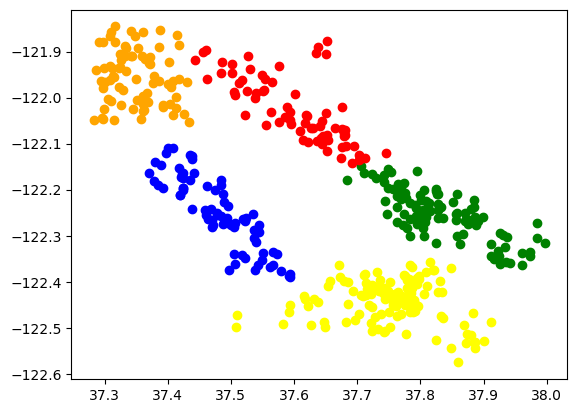

In [155]:
import matplotlib.pyplot as plt

# Load your data here and store it in X
X = df[['lat', 'lng']]
# Initialize the GMM model with 4 components
gmm = GaussianMixture(n_components=5, tol=0.00001)

# Fit the model to your data
gmm.fit(X)

# Predict the clusters for your data
labels = gmm.predict(X)

# Create a scatter plot of the data points colored by their predicted cluster label
for index,i in X.iterrows():
    color = colorDict[labels[index]]
    plt.scatter(i['lat'],i['lng'],color=color)

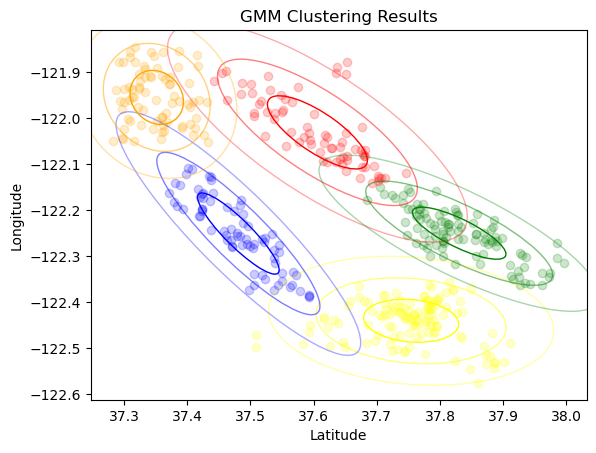

<Figure size 640x480 with 0 Axes>

In [156]:
fig, ax = plt.subplots()
colors= ['red','yellow','blue','green','orange','cyan','purple','black']


# Set the limits of the x and y axis
for index,i in X.iterrows():
    color = colorDict[labels[index]]
    plt.scatter(i['lat'],i['lng'],color=color,alpha=0.2)
for i in range(5):
    covariances = gmm.covariances_[i][:2, :2]
    mean = gmm.means_[i][:2]
    eigenvalues, eigenvectors = np.linalg.eigh(covariances)
    angle = np.degrees(np.arctan2(*eigenvectors[::-1, 0]))
    for j, sd in enumerate([1, 2, 3]):
        width, height = 2 * sd * np.sqrt(eigenvalues)
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=colors[i], facecolor='none', alpha=1/(j+1))
        ax.add_artist(ellipse)
# Add a title and axis labels
plt.title('GMM Clustering Results')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Show the plot
plt.show()
plt.savefig('scikitgmm.png')

# Improved GMM code using Linear Algebra

In [157]:
def meansGet(dat,weights):
    means = np.dot(weights.T, dat)
    pointProbs = np.sum(weights, axis=0)
    nmeans = means / pointProbs[:, np.newaxis]
    return nmeans

def weighted_covariance(data, weights, means):
    k = means.shape[0]
    n = data.shape[0]
    sw = np.sum(weights, axis=0)
    diff = np.repeat(data[np.newaxis,:,:], k, axis=0) - means[:, np.newaxis, :].repeat(n, axis=1)
    wdiff = np.einsum('ikj,ki->ikj', diff, weights)
    cov = np.sum(np.prod(wdiff[:,:,:], axis=2),axis=1) / sw
    v = np.sum(wdiff*diff, axis=1)/sw[:,np.newaxis]
    return np.array([[[v[i,0],cov[i]],[cov[i],v[i,1]]] for i in range(len(means))])

def fast_GMM(data, k, tol=.0000001):
    random.seed(int(time.time()))
    count = 0
    sumProbMax = 0
    n = len(data)
    weights = np.ones(k) / k
    means = np.zeros((k, 2))
    for i in range(k):
        means[i] = (random.choice(data)[0], random.choice(data)[1])
    covars = np.ones((k, 2, 2))
    dataWeights = np.ones((n,k)) /k
    covars = weighted_covariance(data, dataWeights, means)
    convergenceCriteria = False
    
    
    while not convergenceCriteria:
        dataWeights = np.zeros((n,k))
        
        #figuring out the probability of each datapoint being in a cluster
        #SumGaussianWeights = np.zeros(k)
        #sums = np.zeros(n)
        oldTotalProb = sumProbMax
        sumProbMax = 0
        
        for i in range(k):
            currentPdf = stats.multivariate_normal(means[i],covars[i],True)
            dataWC = currentPdf.pdf(data) * weights[i]
            dataWeights[:,i] = dataWC
        #need to normalize this for probaility of each point to be 1 for the sum of the probabilities for guassian
        pointProbs = np.sum(dataWeights, axis=1)
        sumProbMax += np.sum(pointProbs)
        normalizedWeights = dataWeights / pointProbs[:, np.newaxis]
        
        ##recalculate weights for each gaussian
        weights = np.sum(normalizedWeights, axis=0)/n
        
        #Recalculate means and covar
        means = meansGet(data,normalizedWeights)
        covars = weighted_covariance(data,normalizedWeights, means)

        
        #change change to dotproduct
        change = abs(sumProbMax - oldTotalProb)
        
        if count == 1000:
            convergenceCriteria = True
        if change <= tol:
            convergenceCriteria = True
        count+=1
    return means, covars, weights, dataWeights

In [158]:
dat = df[['lat', 'lng']].to_numpy()
means,covars,p_class,p_class_given_data = fast_GMM(dat, 5,.00001)
p_class_given_data
print(np.sum(covars))

0.025655863484258586


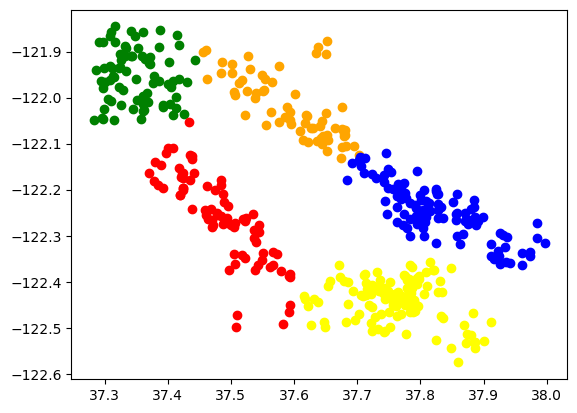

In [159]:
colorDict = {0:'red',1:'yellow',2:'blue',3:'green',4:'orange',5:'cyan',6:'purple',7:'black'}
data = [(i['lat'],i['lng']) for index,i in df.iterrows()]

for index,row in enumerate(data):
    color = None
    maxVal = 0
    for i in range(5):
        val = p_class_given_data[index,i]
        if val > maxVal:
            color = colorDict[i]
            maxVal = val
    plt.scatter(row[0],row[1],color=color)

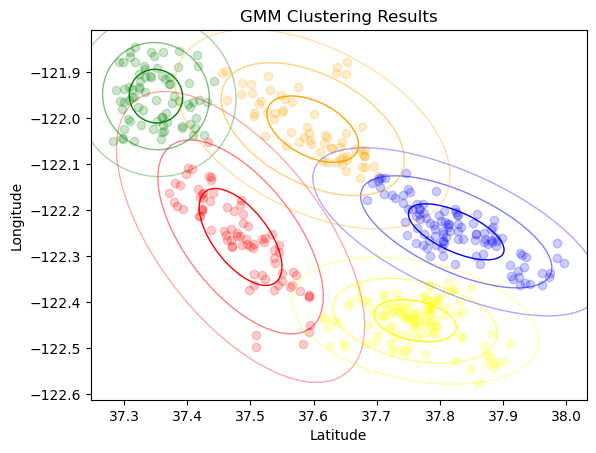

<Figure size 640x480 with 0 Axes>

In [160]:
fig, ax = plt.subplots()
colors= ['red','yellow','blue','green','orange','cyan','purple','black']
for index,row in enumerate(data):
    color = None
    maxVal = 0
    for i in range(5):
        val = p_class_given_data[index,i]
        if val > maxVal:
            color = colorDict[i]
            maxVal = val
    plt.scatter(row[0],row[1],color=color,alpha=0.2)


for i in range(5):
    covariances = covars[i]
    mean = means[i]
    eigenvalues, eigenvectors = np.linalg.eigh(covariances)
    angle = np.degrees(np.arctan2(*eigenvectors[::-1, 0]))
    for j, sd in enumerate([1, 2, 3]):
        width, height = 2 * sd * np.sqrt(eigenvalues)
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=colors[i], facecolor='none', alpha=1/(j+1))
        ax.add_artist(ellipse)
# Add a title and axis labels
plt.title('GMM Clustering Results')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Show the plot
plt.show()
plt.savefig('fastgmm.png')

# Plots for spped and mem usage

In [ ]:
def sci_GMM(X,k,tol):
    gmm = GaussianMixture(n_components=k, tol=tol, max_iter=1000)
    gmm.fit(X)
    labels = gmm.predict(X)

In [ ]:
dat = df[['lat', 'lng']].to_numpy()
data = df[['lat', 'lng']]
tol=.0001
total_timeNG = []
total_timeSG = []
total_timeFG = []
for k in range(2,9):
    def run_naive_gmm():
        data = df[['lat', 'lng']]
        Naive_GMM(data, k, tol)
    def run_sci_gmm():
        data = df[['lat', 'lng']]
        sci_GMM(data,k,tol)
    def run_fast_gmm():
        dat = df[['lat', 'lng']].to_numpy()
        fast_GMM(dat, k, tol)
    total_timeNG.append(timeit.timeit(run_naive_gmm, number=3))
    total_timeSG.append(timeit.timeit(run_sci_gmm, number=3))
    total_timeFG.append(timeit.timeit(run_fast_gmm, number=3))
    print('done',k)


In [ ]:
print(total_timeNG )
print(total_timeSG)
print(total_timeFG)
k=list(np.linspace(2,8,7))
print(k)

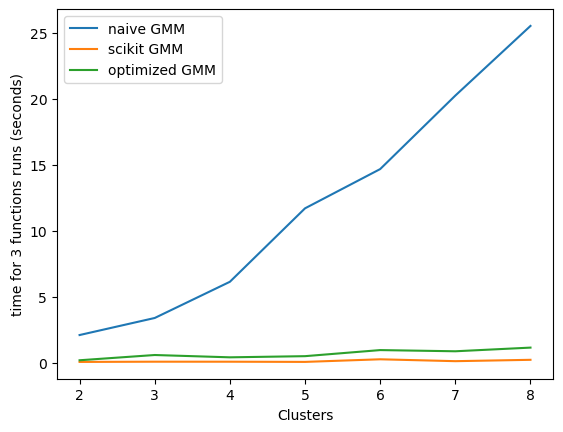

<Figure size 640x480 with 0 Axes>

In [162]:
plt.plot(k,total_timeNG,label='naive GMM')
plt.plot(k,total_timeSG,label='scikit GMM')
plt.plot(k,total_timeFG,label='optimized GMM')
plt.xlabel('Clusters')
plt.ylabel('time for 3 functions runs (seconds)')
plt.legend()
plt.show()
plt.savefig('speed.png')

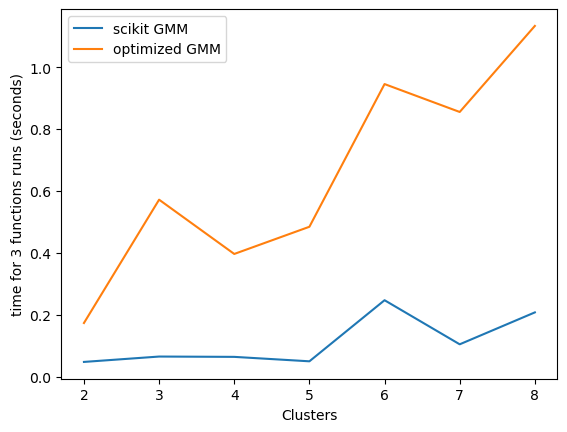

<Figure size 640x480 with 0 Axes>

In [163]:

plt.plot(k,total_timeSG,label='scikit GMM')
plt.plot(k,total_timeFG,label='optimized GMM')
plt.xlabel('Clusters')
plt.ylabel('time for 3 functions runs (seconds)')
plt.legend()
plt.show()
plt.savefig('speed2.png')

In [ ]:
dat = df[['lat', 'lng']].to_numpy()
data = df[['lat', 'lng']]
tol=.0001
total_memNG = []
total_memSG = []
total_memFG = []
for k in range(2,9):
    def run_naive_gmm():
        data = df[['lat', 'lng']]
        Naive_GMM(data, k, tol)
    def run_sci_gmm():
        data = df[['lat', 'lng']]
        sci_GMM(data,k,tol)
    def run_fast_gmm():
        dat = df[['lat', 'lng']].to_numpy()
        fast_GMM(dat, k, tol)
    tracemalloc.start()
    run_naive_gmm()
    snapshot = tracemalloc.take_snapshot()
    top_stats = snapshot.statistics('lineno')
    val = top_stats[0].size / 1024 / 1024
    total_memNG.append(val)
    
    tracemalloc.start()
    run_sci_gmm()
    snapshot = tracemalloc.take_snapshot()
    top_stats = snapshot.statistics('lineno')
    val = top_stats[0].size / 1024 / 1024
    total_memSG.append(val)
    
    tracemalloc.start()
    run_fast_gmm()
    snapshot = tracemalloc.take_snapshot()
    top_stats = snapshot.statistics('lineno')
    val = top_stats[0].size / 1024 / 1024
    total_memFG.append(val)
    
    print('done',k)
print(total_memNG)
print(total_memSG)
print(total_memFG)

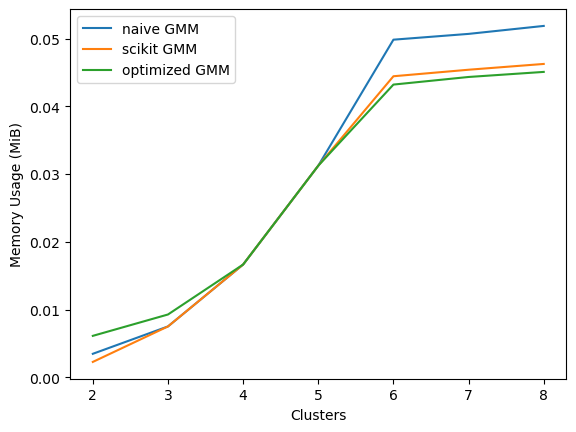

<Figure size 640x480 with 0 Axes>

In [164]:
k=list(np.linspace(2,8,7))
plt.plot(k,total_memNG,label='naive GMM')
plt.plot(k,total_memSG,label='scikit GMM')
plt.plot(k,total_memFG,label='optimized GMM')

plt.xlabel('Clusters')
plt.ylabel('Memory Usage (MiB)')
plt.legend()
plt.show()
plt.savefig('memUsage.png')